# Import Data and Libraries

In [1]:
import csv
import numpy as np
import os

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
dataset = np.load('D:/python_practice/kkstream/datasets/datasets/v0_eigens.npz')

In [4]:
type(dataset)

numpy.lib.npyio.NpzFile

In [5]:
# d = dict(zip(("data1{}".format(k) for k in dataset), (dataset[k] for k in dataset)))
# print(d)

# Preprocessed Data

In [6]:
def predict(features):
    ""
    ""
    # NOTE: guess with random probabilities. the AUC should be closed to 0.5.
    n, v = features.shape

    return np.random.random((n, 28))

In [7]:
def write_result(name, predictions):
    """
    """
    if predictions is None:
        raise Exception('need predictions')

    predictions = predictions.flatten()

    if not os.path.exists('./results/'):
        os.makedirs('./results/')

    path = os.path.join('./results/', name)

    with open(path, 'wt', encoding='utf-8', newline='') as csv_target_file:
        target_writer = csv.writer(csv_target_file, lineterminator='\n')

        header = [
            'user_id',
            'time_slot_0', 'time_slot_1', 'time_slot_2', 'time_slot_3',
            'time_slot_4', 'time_slot_5', 'time_slot_6', 'time_slot_7',
            'time_slot_8', 'time_slot_9', 'time_slot_10', 'time_slot_11',
            'time_slot_12', 'time_slot_13', 'time_slot_14', 'time_slot_15',
            'time_slot_16', 'time_slot_17', 'time_slot_18', 'time_slot_19',
            'time_slot_20', 'time_slot_21', 'time_slot_22', 'time_slot_23',
            'time_slot_24', 'time_slot_25', 'time_slot_26', 'time_slot_27',
        ]

        target_writer.writerow(header)

        for i in range(0, len(predictions), 28):
            # NOTE: 57159 is the offset of user ids
            userid = [57159 + i // 28]
            labels = predictions[i:i+28].tolist()

            target_writer.writerow(userid + labels)

In [8]:
train_data = dataset['train_eigens']

# NOTE: a 896d feature vector for each user, the 28d vector in the end are
#       labels
#       896 = 32 (weeks) x 7 (days a week) x 4 (segments a day)
train_eigens = train_data[:, :-28].reshape(-1, 896)
train_labels = train_data[:, -28:]

# NOTE: read features of test set
test_eigens = dataset['issue_eigens'][:, :-28].reshape(-1, 896)

# NOTE: check the shape of the prepared dataset
print('train_eigens.shape = {}'.format(train_eigens.shape)) #train X
print('train_labels.shape = {}'.format(train_labels.shape)) #train y

train_eigens.shape = (57159, 896)
train_labels.shape = (57159, 28)


In [14]:
#df = pd.DataFrame(data=train_eigens)

In [27]:
#df_y = pd.DataFrame(data=train_labels) #未來一周內 使用者是否在這個時段看劇

In [16]:
#df_valid = pd.DataFrame(data=valid_eigens)

In [26]:
#df_valid_y = pd.DataFrame(data=valid_labels)

In [9]:
df_test = pd.DataFrame(data=test_eigens)

In [10]:
all_train = pd.DataFrame(data=dataset['train_eigens'][:, :-28].reshape(-1, 896))

In [11]:
all_train_y = pd.DataFrame(data=dataset['train_eigens'][:, -28:])

# Create New Features

In [12]:
def new_feature(train):
    for i in range(1,9): #整理最近 i 周的觀看次數
        if i == 1:
            temp = train.iloc[:,(train.shape[1]-28*i):].apply(sum,axis=1) #計算每一週
            new = pd.concat([train, temp], axis=1)
        else:
            temp = train.iloc[:,(train.shape[1]-28*i):(train.shape[1]-28*(i-1)):].apply(sum,axis=1) #計算每一週
            new = pd.concat([new, temp], axis=1)
    
    mon = new.iloc[:,new.shape[1]-4:].apply(sum,axis=1) #最近1個月的觀看次數
    mon2 = new.iloc[:,new.shape[1]-8:new.shape[1]-4].apply(sum,axis=1) #最近2個月的觀看次數
    new = pd.concat([new, mon, mon2], axis=1)
    new.columns = [x for x in range(0,new.shape[1])]
    
    return new

In [13]:
np.array(range(all_train.shape[1]))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [14]:
new_train = new_feature(all_train)

In [15]:
new_train = new_feature(all_train)

In [17]:
new_train.head()

,0,1,2,3,4,5,6,7,8,9,...,896,897,898,899,900,901,902,903,904,905
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,18.0,20.0,21.0,21.0,12.0,0.0,0.0,33.0,70.0


In [18]:
(new_train.iloc[0,:896]==all_train.iloc[0,:]).sum()

896

In [19]:
new_test = new_feature(df_test)

In [20]:
new_test.shape

(37092, 906)

In [21]:
new_test.head()

,0,1,2,3,4,5,6,7,8,9,...,896,897,898,899,900,901,902,903,904,905
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,9.0,13.0,22.0,11.0,8.0,18.0,21.0,58.0,59.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,6.0,15.0,4.0,0.0,25.0,16.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,2.0,2.0,0.0,0.0,4.0,2.0,2.0,8.0,9.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


# Train

## some functions

In [64]:
def cm(y_test, y_pred): #plot confusion matrix function
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(np.array(y_test), y_pred) #plot confusion matrix
    df_cm = pd.DataFrame(confusion_matrix, range(2),range(2))
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap="YlGnBu")# font size
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [65]:
def class_view(y_test, y_pred): #view classification report
    from sklearn.metrics import classification_report
    print(classification_report(np.array(y_test), y_pred))

In [66]:
def plot_roc(X_test, y_test, model):
    y_score = model.predict_proba(X_test)[:,1]
    rf_roc_auc_lr = roc_auc_score(np.array(y_test), y_score)
    print("AUC = %.4f" % rf_roc_auc_lr)
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(np.array(y_test), y_score)
    plt.figure()
    plt.plot(fpr_lr, tpr_lr, label='%s (area = %0.2f)' % ('model', rf_roc_auc_lr) )
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [67]:
def precision_recall_curve(X_test, y_test, model):
    
    y_score = model.predict_proba(X_test)[:,1]
    
    precision_lr, recall_lr, thresholds_lr = precision_recall_curve(np.array(y_test), y_score)

    plt.step(recall_lr, precision_lr, color='b', alpha=0.2, where='post')
    plt.fill_between(recall_lr, precision_lr, step='post', alpha=0.2, color='b')

    close_zero = np.argmin(np.abs(thresholds_lr-0.5)) #auc最大時的threshold
    f1_lr=2*precision_lr*recall_lr/(precision_lr+recall_lr)
    index_lr=np.argmax(f1_lr) #改成讓f1最大的threshold(之後享用的)

    plt.scatter(recall_lr[close_zero], precision_lr[close_zero],c='b',marker='o',label='f1 = %.2f logistic' % f1_lr[close_zero])
    plt.scatter(recall_lr[index_lr], precision_lr[index_lr],c='r',marker='^',label='f1 = %.2f logistic' % f1_lr[index_lr])

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='best')
    plt.title('2-class Precision-Recall curve of Logistic Regression')

    print('threshold of best f1 : {:.3f}'.format(thresholds_lr[index_lr]))
    print('threshold of train   : {:.3f}'.format(thresholds_lr[close_zero]))

In [22]:
train_data_size = dataset['train_eigens'].shape[0]
valid_data_size = train_data_size // 5
train_data_size = train_data_size - valid_data_size

# NOTE: split dataset
train_data = new_train.iloc[:train_data_size,:]
valid_data = new_train.iloc[train_data_size:,:]

#label
train_label = train_labels[:train_data_size,:]
valid_label = train_labels[train_data_size:,:]

## Logistic

In [ ]:
lr = LogisticRegression(C=0.1)
for i in range(0,28):
    lr.fit(train_data, train_label[:,i]) #train
    pred_y = lr.predict_proba(valid_data)[:,1] #prediction on validation set
    
    print("i = %d" % i)   
    lr_roc_auc = roc_auc_score(valid_label[:,i], pred_y)
    print("AUC: %5f" % lr_roc_auc )

In [79]:
#prediction on testing data
lr = LogisticRegression(C=0.1)
for i in range(0,28):
    
    lr.fit(new_train, all_train_y.iloc[:,i]) #train
    pred_y = lr.predict_proba(new_test)[:,1] #prediction on test set
    
    if i==0:
        lr_ans = np.array([pred_y]).reshape(37092,1)
    else:
        lr_ans = np.concatenate((lr_ans, np.array([pred_y]).reshape(37092,1)), axis=1)

KeyboardInterrupt: 

In [ ]:
lr_ans.shape

In [112]:
lr_ans

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [113]:
write_result('logistic_new_feature_0803.csv', lr_ans) #0.64663

## Random Forest

In [ ]:
# Train model
rf = RandomForestClassifier(random_state=10,n_jobs=-1,max_depth=5)

for i in range(0,28):
    rf.fit(train_data, train_label[:,i]) #train
    pred_y = rf.predict_proba(valid_data)[:,1] #prediction on validation set
    
    print("i = %d" % i)   
    rf_roc_auc = roc_auc_score(valid_label[:,i], pred_y)
    print("AUC: %5f" % rf_roc_auc )

In [77]:
# wirte prediction on test 
rf = RandomForestClassifier(random_state=10,n_jobs=-1,max_depth=5)

for i in range(0,28):
    
    rf.fit(new_train, all_train_y.iloc[:,i]) #train
    pred_y = rf.predict_proba(new_test)[:,1] #prediction on test set
    
    if i==0:
        rf_ans = np.array([pred_y]).reshape(37092,1)
    else:
        rf_ans = np.concatenate((rf_ans, np.array([pred_y]).reshape(37092,1)), axis=1)

In [78]:
rf_ans.shape

(37092, 28)

In [21]:
write_result('rf_new_feature2.csv', rf_ans)

## XGBoost

In [43]:
import xgboost as xgb

In [30]:
train_data_size = dataset['train_eigens'].shape[0]
valid_data_size = train_data_size // 5
train_data_size = train_data_size - valid_data_size

# NOTE: split dataset
train_data = new_train.iloc[:train_data_size,:]
valid_data = new_train.iloc[train_data_size:,:]

#label
train_label = train_labels[:train_data_size,:]
valid_label = train_labels[train_data_size:,:]

In [45]:
for i in range(0,28):
    
    dtrain = xgb.DMatrix(train_data, label=train_label[:,i])
    dtest = xgb.DMatrix(valid_data, label=valid_label[:,i])
    param = {
        'max_depth': 4,  # the maximum depth of each tree
        'eta': 0.1,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective': "binary:logistic",  # error evaluation for multiclass training
        'subsample': 0.7,
        'colsample_bytree':0.7,
        'scale_pos_weight':0.8
    }  # the number of classes that exist in this datset
    num_round = 30  # the number of training iterations

    bst = xgb.train(param, dtrain, num_round)
    
    pred_y = bst.predict(dtest)
    print("i = %d" % i)
    
    print("Plot ROC Curve:")
    rf_roc_auc_xg = roc_auc_score(valid_label[:,i], pred_y)
    print("AUC: %5f" % rf_roc_auc_xg )

i = 0
Plot ROC Curve:
AUC: 0.868413
i = 1
Plot ROC Curve:
AUC: 0.870696
i = 2
Plot ROC Curve:
AUC: 0.890432
i = 3
Plot ROC Curve:
AUC: 0.889365
i = 4
Plot ROC Curve:
AUC: 0.867270
i = 5
Plot ROC Curve:
AUC: 0.865238
i = 6
Plot ROC Curve:
AUC: 0.871885
i = 7
Plot ROC Curve:
AUC: 0.896977
i = 8
Plot ROC Curve:
AUC: 0.865029
i = 9
Plot ROC Curve:
AUC: 0.858913
i = 10
Plot ROC Curve:
AUC: 0.873931
i = 11
Plot ROC Curve:
AUC: 0.903446
i = 12
Plot ROC Curve:
AUC: 0.868412
i = 13
Plot ROC Curve:
AUC: 0.835525
i = 14
Plot ROC Curve:
AUC: 0.860583
i = 15
Plot ROC Curve:
AUC: 0.885560
i = 16
Plot ROC Curve:
AUC: 0.851296
i = 17
Plot ROC Curve:
AUC: 0.838430
i = 18
Plot ROC Curve:
AUC: 0.839924
i = 19
Plot ROC Curve:
AUC: 0.842448
i = 20
Plot ROC Curve:
AUC: 0.820546
i = 21
Plot ROC Curve:
AUC: 0.817366
i = 22
Plot ROC Curve:
AUC: 0.822558
i = 23
Plot ROC Curve:
AUC: 0.823617
i = 24
Plot ROC Curve:
AUC: 0.817676
i = 25
Plot ROC Curve:
AUC: 0.824826
i = 26
Plot ROC Curve:
AUC: 0.831823
i = 27
Plot

In [70]:
for i in range(0,28):
    
    dtrain = xgb.DMatrix(new_train, label=all_train_y.iloc[:,i])
    dtest = xgb.DMatrix(new_test)
    param = {
        'max_depth': 4,  # the maximum depth of each tree
        'eta': 0.1,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective': "binary:logistic",  # error evaluation for multiclass training
        'subsample': 0.7,
        'colsample_bytree':0.7,
        'scale_pos_weight':0.8
    }  # the number of classes that exist in this datset
    num_round = 20  # the number of training iterations

    bst = xgb.train(param, dtrain, num_round)
    
    pred_y = bst.predict(dtest)
    
    if i==0:
        xg_ans = np.array([pred_y]).reshape(-1,1)
    else:
        xg_ans = np.concatenate((xg_ans, np.array([pred_y]).reshape(-1,1)), axis=1)

In [71]:
xg_ans.shape

(37092, 28)

In [72]:
xg_ans

array([[0.59972715, 0.665579  , 0.4815127 , ..., 0.5395125 , 0.3147311 ,
        0.11568728],
       [0.13712314, 0.2026348 , 0.08579614, ..., 0.18484157, 0.08997382,
        0.07197876],
       [0.08039546, 0.08813655, 0.07207277, ..., 0.08960611, 0.0752398 ,
        0.07072333],
       ...,
       [0.08083578, 0.09773013, 0.07207277, ..., 0.10771769, 0.0752398 ,
        0.07072333],
       [0.08867411, 0.09736079, 0.07207277, ..., 0.10310432, 0.0768294 ,
        0.07072333],
       [0.50005513, 0.25855422, 0.08713689, ..., 0.24006794, 0.09885231,
        0.14248355]], dtype=float32)

In [49]:
write_result('xgboost_new_feature_0803.csv', ans) # 08/03: 0.87475

In [56]:
#write_result('xgboost_test2.csv', ans) # 08/01: 0.86563

In [55]:
#write_result('xgboost_test.csv', ans) # 07/31: 0.86905

#### LGBM

In [28]:
import lightgbm as lgb
from statistics import mean

In [52]:
learn_rate = [0.070,0.074,0.078]
depth = [61,71,81]

In [53]:
#Validation check AUC
for i in range(0,len(learn_rate)):
    for k in range(0,len(depth)):
        roc_lg = 0
        for j in range(0,28):

            d_train = lgb.Dataset(train_data, label=train_label[:,j])

            params = {}

            params['learning_rate'] = learn_rate[i]
            params['boosting_type'] = 'gbdt'
            params['objective'] = 'binary'
            params['metric'] = 'auc'
            params['sub_feature'] = 0.7
            params['num_leaves'] = depth[k]
            params['min_data'] = 50
            params['max_depth'] = -1

            clf = lgb.train(params, d_train, 50)

            #Prediction
            pred_y = clf.predict(valid_data)

            #print("j = %d" % j)

            #print("Plot ROC Curve:")
            if j==0:
                roc_lg = roc_auc_score(valid_label[:,j], pred_y)
            else:
                roc_lg = np.c_[roc_lg, roc_auc_score(valid_label[:,j], pred_y)]
        
        roc = np.mean(roc_lg)
        
        print("Learning rate: %.3f " % learn_rate[i])
        print("num_leaves: %d " % depth[k])
        print("AUC: %.4f" % roc)

Learning rate: 0.07 
num_leaves: 61 
AUC: 0.8672
Learning rate: 0.07 
num_leaves: 71 
AUC: 0.8677
Learning rate: 0.07 
num_leaves: 81 
AUC: 0.8665
Learning rate: 0.07 
num_leaves: 61 
AUC: 0.8675
Learning rate: 0.07 
num_leaves: 71 
AUC: 0.8670
Learning rate: 0.07 
num_leaves: 81 
AUC: 0.8671
Learning rate: 0.08 
num_leaves: 61 
AUC: 0.8672
Learning rate: 0.08 
num_leaves: 71 
AUC: 0.8669
Learning rate: 0.08 
num_leaves: 81 
AUC: 0.8670


In [62]:
#Validation check AUC
for j in range(0,28):

    d_train = lgb.Dataset(train_data, label=train_label[:,j])
    
    params = {}
    
    params['learning_rate'] = 0.05
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    params['sub_feature'] = 0.7
    params['num_leaves'] = 51
    params['min_data'] = 50
    params['max_depth'] = -1
    
    clf = lgb.train(params, d_train, 50)
    
    #Prediction
    pred_y = clf.predict(valid_data)

    #print("j = %d" % j)
    
    #print("Plot ROC Curve:")
    roc_auc_lg = roc_auc_score(valid_label[:,j], pred_y)
    print("AUC: %5f" % roc_auc_lg)

j = 0
AUC: 0.878778
j = 1
AUC: 0.876818
j = 2
AUC: 0.904476
j = 3
AUC: 0.902020
j = 4
AUC: 0.876221
j = 5
AUC: 0.869831
j = 6
AUC: 0.883727
j = 7
AUC: 0.902756
j = 8
AUC: 0.872989
j = 9
AUC: 0.864335
j = 10
AUC: 0.882762
j = 11
AUC: 0.907063
j = 12
AUC: 0.874053
j = 13
AUC: 0.841368
j = 14
AUC: 0.871774
j = 15
AUC: 0.893516
j = 16
AUC: 0.861455
j = 17
AUC: 0.842411
j = 18
AUC: 0.858710
j = 19
AUC: 0.853395
j = 20
AUC: 0.826993
j = 21
AUC: 0.821574
j = 22
AUC: 0.839492
j = 23
AUC: 0.835664
j = 24
AUC: 0.823346
j = 25
AUC: 0.829331
j = 26
AUC: 0.845548
j = 27
AUC: 0.878318


In [54]:
for j in range(0,28):
    
    print("j = %d" % j)
    d_train = lgb.Dataset(new_train, label=all_train_y.iloc[:,j])

    params = {}
    
    params['learning_rate'] = 0.07
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    params['sub_feature'] = 0.7
    params['num_leaves'] = 71
    params['min_data'] = 50
    params['max_depth'] = -1
    
    clf = lgb.train(params, d_train, 500)
    
    #Prediction
    pred_y = clf.predict(new_test)

    if j==0:
        ans = np.array([pred_y]).reshape(-1,1)
    else:
        ans = np.concatenate((ans, np.array([pred_y]).reshape(-1,1)), axis=1)

j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
j = 6
j = 7
j = 8
j = 9
j = 10
j = 11
j = 12
j = 13
j = 14
j = 15
j = 16
j = 17
j = 18
j = 19
j = 20
j = 21
j = 22
j = 23
j = 24
j = 25
j = 26
j = 27


In [55]:
ans.shape

(37092, 28)

In [48]:
ans

array([[0.81152359, 0.79697921, 0.57278363, ..., 0.47399536, 0.26816297,
        0.10824046],
       [0.05270711, 0.22101988, 0.01936235, ..., 0.14388499, 0.02760276,
        0.00534919],
       [0.01041625, 0.01738729, 0.00436066, ..., 0.03278624, 0.00611473,
        0.00271237],
       ...,
       [0.01243831, 0.03565887, 0.00471516, ..., 0.02908804, 0.0063904 ,
        0.00319474],
       [0.02173417, 0.02556303, 0.00794366, ..., 0.05137536, 0.01862341,
        0.01621953],
       [0.37905331, 0.18862668, 0.0097221 , ..., 0.26338505, 0.00515729,
        0.23454511]])

In [56]:
write_result('LGBM_new_feature_0807_3.csv', ans) #0.883

In [80]:
rf_ans[0,:]

array([0.62079917, 0.50849424, 0.19009618, 0.12625895, 0.6603199 ,
       0.5180822 , 0.26165201, 0.1608525 , 0.65643804, 0.56911885,
       0.25214492, 0.21608081, 0.64815623, 0.53646505, 0.20883716,
       0.18016346, 0.58329303, 0.53680887, 0.20793879, 0.07713431,
       0.33938123, 0.37686095, 0.19018085, 0.09200974, 0.41307636,
       0.43068324, 0.2560959 , 0.05565103])

In [82]:
xg_ans[0,:]

array([0.59972715, 0.665579  , 0.4815127 , 0.19161338, 0.6598043 ,
       0.692936  , 0.33800346, 0.1257573 , 0.6274808 , 0.64631313,
       0.30412063, 0.20228615, 0.6412565 , 0.57783175, 0.35228893,
       0.17958137, 0.58169794, 0.5544403 , 0.30058512, 0.21654655,
       0.41111672, 0.44264752, 0.30104288, 0.16451016, 0.38954622,
       0.5395125 , 0.3147311 , 0.11568728], dtype=float32)

In [83]:
ans[0,:]

array([0.78955391, 0.73962246, 0.61242014, 0.18142379, 0.77425714,
       0.71959609, 0.51884437, 0.17438887, 0.7277571 , 0.72119237,
       0.34550866, 0.25456072, 0.66621283, 0.65367898, 0.44219292,
       0.2845832 , 0.72972767, 0.57727268, 0.30973541, 0.16156919,
       0.39528763, 0.47629519, 0.30391021, 0.17052081, 0.50841805,
       0.58414816, 0.48284403, 0.09978883])

In [85]:
def probability_to_rank(prediction, scaler=1):
    pred_df=pd.DataFrame(columns=['probability'])
    pred_df['probability']=prediction
    pred_df['rank']=pred_df['probability'].rank()/len(prediction)*scaler
    return pred_df['rank'].values

In [86]:
probability_to_rank(ans[0,:],1)

array([1.        , 0.92857143, 0.67857143, 0.17857143, 0.96428571,
       0.78571429, 0.57142857, 0.14285714, 0.85714286, 0.82142857,
       0.35714286, 0.21428571, 0.75      , 0.71428571, 0.42857143,
       0.25      , 0.89285714, 0.60714286, 0.32142857, 0.07142857,
       0.39285714, 0.46428571, 0.28571429, 0.10714286, 0.53571429,
       0.64285714, 0.5       , 0.03571429])

#### Sequential

In [45]:
import random
sample = random.sample(range(0,train_data.shape[0]), 30000) #人數太多跑不動，因此採用抽樣方式
sample_v = random.sample(range(0,valid_data.shape[0]), 10000) #人數太多跑不動，因此採用抽樣方式

all_d = train_data[sample,784:]
all_valid = valid_data[sample_v,784:]
all_d.shape

(30000, 140)

In [46]:
train_data.shape[0]

45728

In [47]:
all_valid.shape

(10000, 140)

In [48]:
result = [] #train
for i in range(0,all_d.shape[0]):
    for index in range(0,28):
        result.append(all_d[i,index: index + 113])

In [49]:
result2 = [] #validation
for i in range(0,all_valid.shape[0]):
    for index in range(0,28):
        result2.append(all_valid[i,index: index + 113])

In [50]:
test = [] #test_data
for i in range(0,test_eigens.shape[0]):
    for index in range(0,28):
        test.append(test_eigens[i,index: index + 112])

In [51]:
result = np.array(result)
result2 = np.array(result2)

In [52]:
result.shape

(840000, 113)

In [53]:
result2.shape

(280000, 113)

In [54]:
test = np.array(test)
test.shape

(1038576, 112)

In [55]:
np.random.shuffle(result)
np.random.shuffle(result2)
X_train = result[:, :-1]
y_train = result[:, -1]
X_valid = result2[:, :-1]
y_valid = result2[:, -1]

In [56]:
X_train.shape

(840000, 112)

<class 'numpy.ndarray'>
Confusion Matrix: 
Classification Report:
             precision    recall  f1-score   support

        0.0       0.94      0.99      0.96    254257
        1.0       0.72      0.37      0.49     25743

avg / total       0.92      0.93      0.92    280000

Plot ROC Curve:


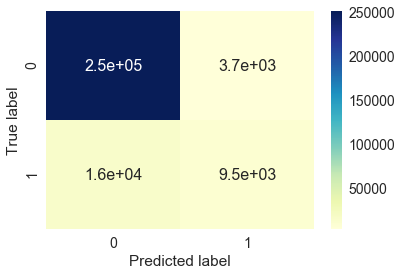

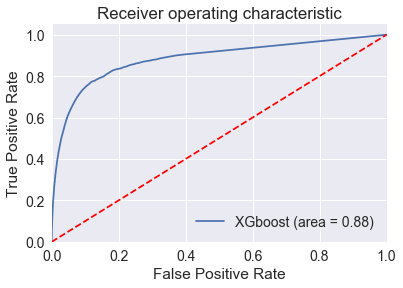

In [57]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_valid, label=y_valid)
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': "binary:logistic",  # error evaluation for multiclass training
    'subsample': 0.65,
    'colsample_bytree':0.7,
    'scale_pos_weight':0.9
}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)

pred_y = bst.predict(dtest)
print(type(pred_y))

print("Confusion Matrix: ")

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, (pred_y > .5).astype(int))
df_cm = pd.DataFrame(cm, range(2), range(2))
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap="YlGnBu")# font size
plt.ylabel('True label')
plt.xlabel('Predicted label')

from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report( y_valid, (pred_y > .5).astype(int) ))

#print("Precision-Recall Curve:")
#precision_recall_curve(df_valid, df_valid_y.iloc[:,i])

print("Plot ROC Curve:")
rf_roc_auc_xg = roc_auc_score( y_valid, pred_y )
fpr_xg, tpr_xg, thresholds_xg = roc_curve( y_valid, pred_y )
plt.figure()
plt.plot(fpr_xg, tpr_xg, label='XGboost (area = %0.2f)' % rf_roc_auc_xg)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGboost_ROC')
plt.show()

In [58]:
X_train = np.concatenate((X_train, X_valid), axis=0)
y_train = np.concatenate((y_train, y_valid), axis=0)

In [59]:
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': "binary:logistic",  # error evaluation for multiclass training
    'subsample': 0.65,
    'colsample_bytree':0.7,
    'scale_pos_weight':0.9
}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

dtrain = xgb.DMatrix(X_train, label=y_train)
bst = xgb.train(param, dtrain, num_round)

for i in range(0,28):
    if i==0:
        #dtrain = xgb.DMatrix(X_train, label=y_train)
        print(i)
        dtest = xgb.DMatrix(test[ np.array([x for x in range(0, 1038576, 28)]) , i:])
        pred_y = bst.predict(dtest)
        ans = np.array([pred_y]).reshape(37092,1)
    elif i==1:
        print(i)
        t = np.concatenate(( test[np.array([x for x in range(i, 1038576, 28)]), i:], pred_y.reshape(37092,1) ), axis=1)
        dtest = xgb.DMatrix(t)
        pred_y = bst.predict(dtest)
        ans = np.concatenate((ans, np.array([pred_y]).reshape(37092,1)), axis=1)
    else:
        t = np.concatenate((t[:, 1:], pred_y.reshape(37092,1) ), axis=1)
        dtest = xgb.DMatrix(t)
        pred_y = bst.predict(dtest)
        ans = np.concatenate((ans, np.array([pred_y]).reshape(37092,1)), axis=1)

0
1


In [60]:
ans.shape

(37092, 28)

In [61]:
write_result('sequential_test_2.csv', ans) #0.55566

In [41]:
write_result('sequential_test.csv', ans) #0.55781